<a href="https://colab.research.google.com/github/Shiromasteven/Sales-predictions/blob/main/Sales_Predictions_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing Code

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn import set_config
set_config(display='diagram')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

filename = '/content/drive/MyDrive/sales_predictions (1).csv'

df = pd.read_csv(filename)

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


##Begin Code Cleaning Process

In [150]:
#Reserve a unprocessed copy for machine learning imputation later to avoid data leakage

ML_df = df.copy()

In [151]:
df.shape

(8523, 12)

In [152]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [153]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
8518    False
8519    False
8520    False
8521    False
8522    False
Length: 8523, dtype: bool

In [154]:
df.duplicated().sum()

0

In [155]:
df.nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

In [156]:
df.isna()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,False,False,False,False,False,False,False,False,False,False,False,False
8519,False,False,False,False,False,False,False,False,True,False,False,False
8520,False,False,False,False,False,False,False,False,False,False,False,False
8521,False,False,False,False,False,False,False,False,False,False,False,False


In [157]:
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [158]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [159]:
#Because we have the store type column, and the size of the store can be inferenced by the type, I feel it is necessary to drop the Outlet_Size column.
#However for the item weight, as this is a large portion of information and can be filled in with a mean value of the item's weights based on their Item_Type avg.

df.groupby('Item_Type')['Item_Weight'].mean().round(2)

Item_Type
Baking Goods             12.28
Breads                   11.35
Breakfast                12.77
Canned                   12.31
Dairy                    13.43
Frozen Foods             12.87
Fruits and Vegetables    13.22
Hard Drinks              11.40
Health and Hygiene       13.14
Household                13.38
Meat                     12.82
Others                   13.85
Seafood                  12.55
Snack Foods              12.99
Soft Drinks              11.85
Starchy Foods            13.69
Name: Item_Weight, dtype: float64

In [160]:
df['Item_Weight'].describe()

count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64

In [161]:
## I have found a large selection of item weights to be missing, I will fill this in with the mean of all the item weights and later run exploratory analysis.

median_weight = df['Item_Weight'].mean()
df['Item_Weight'].fillna(median_weight, inplace = True)

df.isna().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [162]:
#I could find no corrrelation between the Nan's and therefor no suitable imputation method. Dropping column
df.drop(columns = 'Outlet_Size', inplace = True)


In [163]:
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [164]:
df['Item_Fat_Content'].value_counts()


Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [165]:
#Combining like indexes that where similarly labeled

df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [166]:
df['Item_Weight'].min()

4.555

In [167]:
def sumstats(df):
  print(df.min())
  print(df.max())
  print(df.mean())



In [168]:
sumstats(df['Item_Weight'])


4.555
21.35
12.857645184135976


In [169]:
sumstats(df['Item_Visibility'])

0.0
0.328390948
0.06613202877895108


In [170]:
sumstats(df['Item_MRP'])

31.29
266.8884
140.9927819781767


In [171]:
sumstats(df['Item_Outlet_Sales'])

33.29
13086.9648
2181.288913575032


##Begin Exploratory Analysis

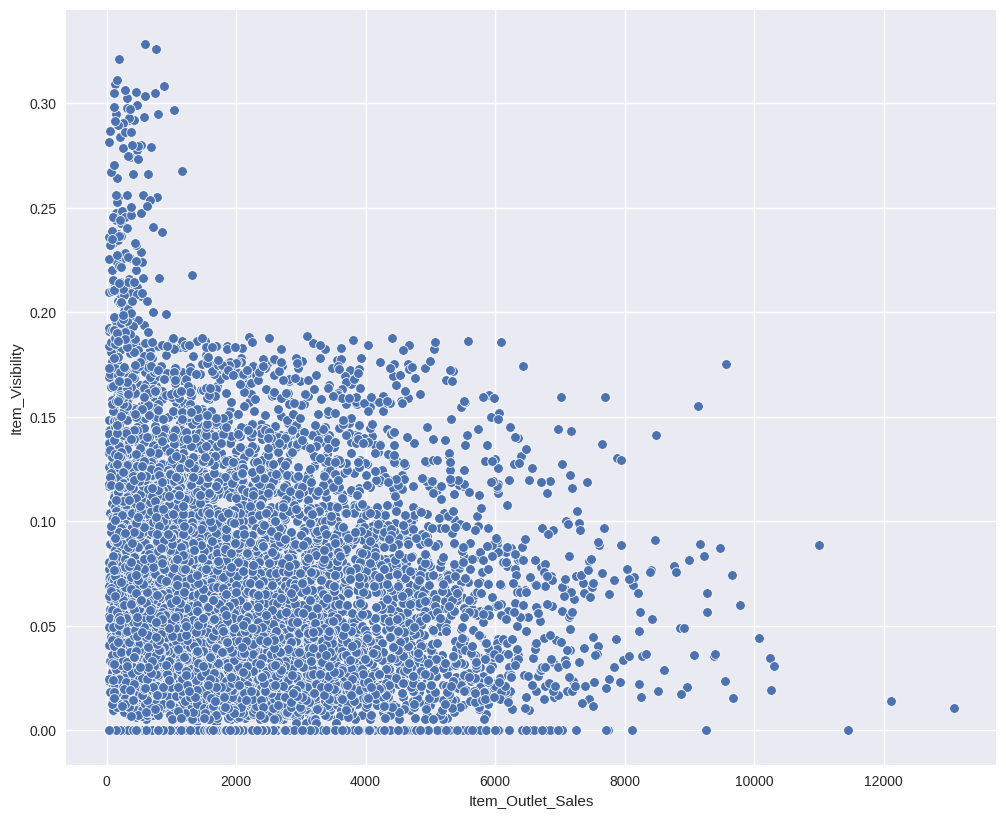

In [172]:
#Looking for correlation between Visibility and item sales.
image_test = plt.figure(figsize=(12,10), dpi= 100)
sns.scatterplot(data=df, x = "Item_Outlet_Sales", y = 'Item_Visibility')

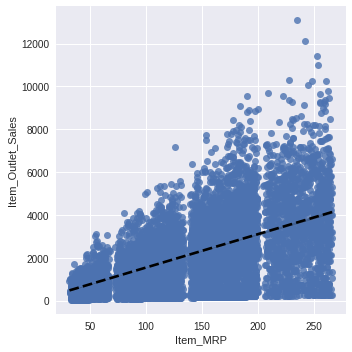

In [173]:
#Finding correlation between MRP and Sales via best fit line

sns.lmplot(data = df, x = 'Item_MRP', y = 'Item_Outlet_Sales', line_kws={'color': 'black', 'ls': '--'}
)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 0, 'Item Type')

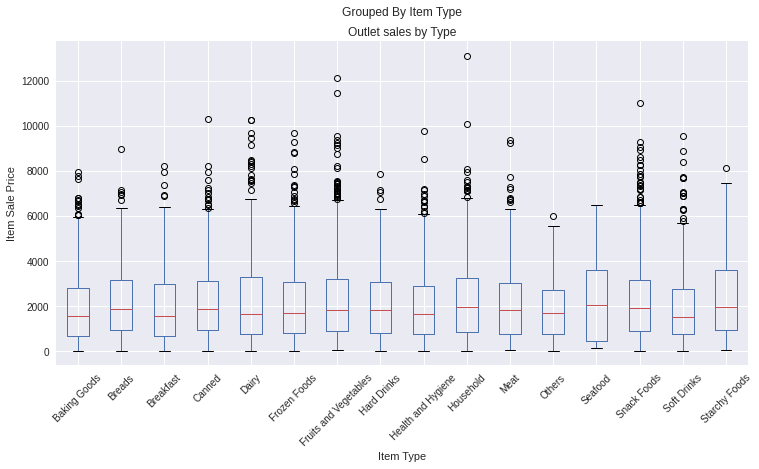

In [174]:
#Here I am comparing the item type category with it's item sales to find higher than average sales, median sales, and overall market prices

df.boxplot(column = 'Item_Outlet_Sales', by = 'Item_Type', figsize = (12,6));
plt.xticks(rotation = 45)
plt.title('Outlet sales by Type');
plt.suptitle('Grouped By Item Type');
plt.ylabel('Item Sale Price')
plt.xlabel('Item Type')

Text(0.5, 0, 'Sales Amount')

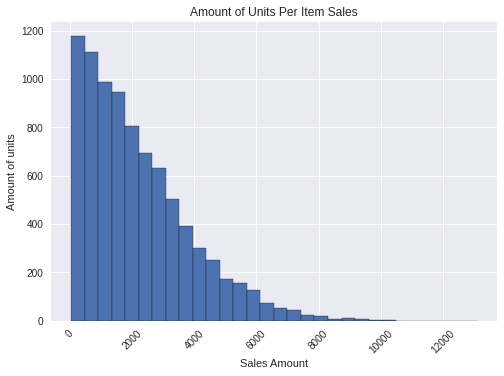

In [175]:
#Here I am comparing the different types of stores and their sales margins.


plt.style.use('seaborn')
df['Item_Outlet_Sales'].hist(bins = 30,
                                   edgecolor='black')
plt.xticks(rotation = 45)

plt.title('Amount of Units Per Item Sales');
plt.ylabel('Amount of units')
plt.xlabel('Sales Amount')


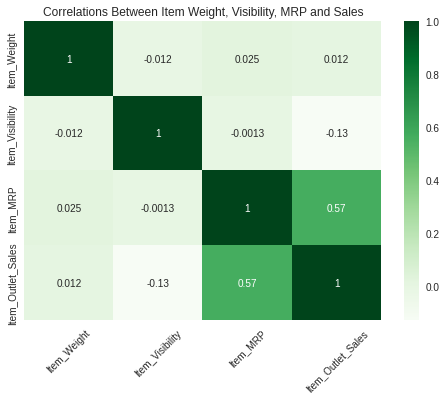

In [176]:
# Below we have a heat map of the Item weight, visibility, mrp and sales, with a correlation btween mrp and sales and an inverse correlation between visibility and the other variables.

df_heat = df.drop(columns = ['Item_Identifier',	'Outlet_Identifier',	'Outlet_Establishment_Year',	'Outlet_Location_Type',	'Outlet_Type'])

df_heat_corr = df_heat.corr()

sns.heatmap(df_heat_corr, cmap = 'Greens', annot = True);
plt.xticks(rotation = 45)
plt.title('Correlations Between Item Weight, Visibility, MRP and Sales');

##Begin Explanatory analysis


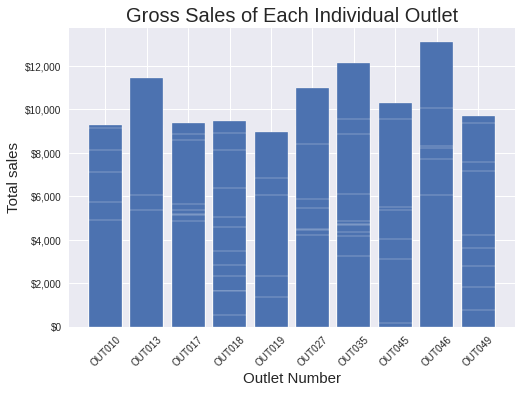

In [177]:
#A bar graph of the different stores sales


fig, ax = plt.subplots()
price_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')

plt.bar(df['Outlet_Identifier'].sort_values(), df['Item_Outlet_Sales'])
plt.ylabel('Total sales', fontsize = 15)
plt.xlabel('Outlet Number', fontsize = 15)
plt.title('Gross Sales of Each Individual Outlet', fontsize = 20)
plt.xticks(rotation = 45)
ax.yaxis.set_major_formatter(price_fmt)

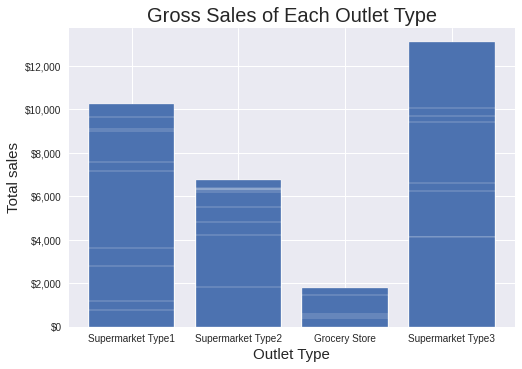

In [178]:
#Comparing the sales made of each outlet type


fig, ax = plt.subplots()
price_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')


plt.style.use('seaborn')
plt.bar(df['Outlet_Type'], df['Item_Outlet_Sales'])
plt.ylabel('Total sales', fontsize = 15)
plt.xlabel('Outlet Type', fontsize = 15)
plt.title('Gross Sales of Each Outlet Type', fontsize = 20)
ax.yaxis.set_major_formatter(price_fmt)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 864x864 with 0 Axes>

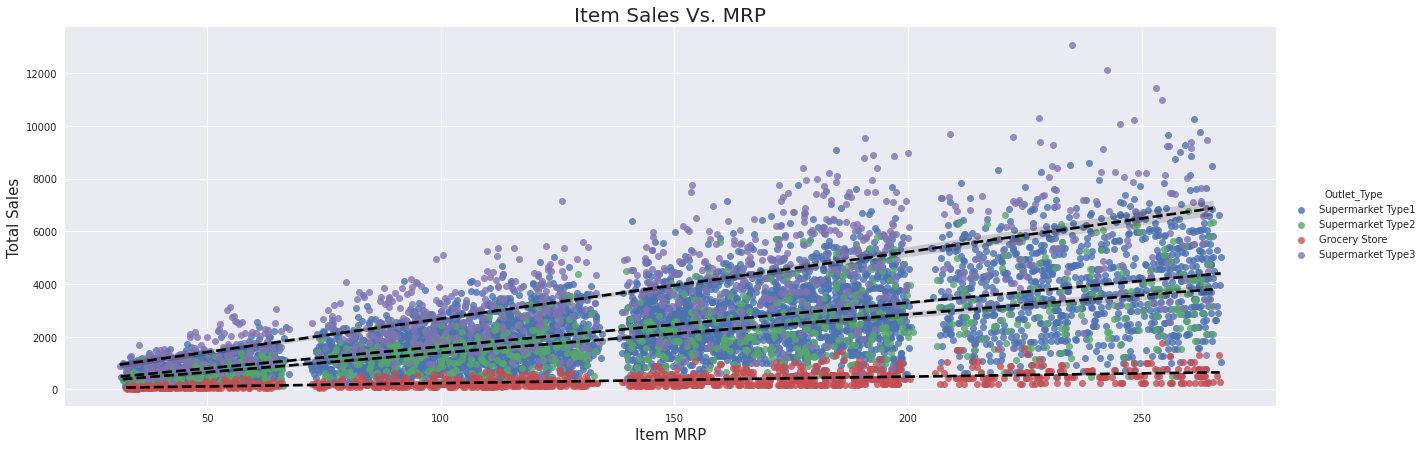

In [179]:
#Comparing sales of items against their MRP and which markets are contributing those sales.

sns.set_style("darkgrid")

plt.figure(figsize = (12,12))

Item_Sales_VS_MRP = sns.lmplot(data = df, x = 'Item_MRP', y = 'Item_Outlet_Sales', hue = 'Outlet_Type', height = 6, aspect = 3, line_kws={'color': 'black', 'ls': '--'}
)
plt.title('Item Sales Vs. MRP', fontsize = 20)
plt.ylabel('Total Sales', fontsize = 15)
plt.xlabel('Item MRP', fontsize = 15)


Item_Sales_VS_MRP.savefig('Item_Sales_VS_MRP.png',  bbox_inches="tight")
files.download('Item_Sales_VS_MRP.png')

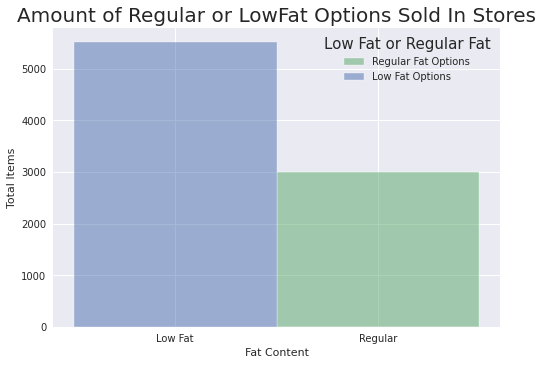

In [180]:
#Comparing the fat content of items sold in all stores.

plt.title('Amount of Regular or LowFat Options Sold In Stores', fontsize = 20)
sns.histplot(data = df, x = 'Item_Fat_Content', hue = 'Item_Fat_Content')
plt.ylabel('Total Items')
plt.xlabel('Fat Content')
legend = plt.legend(['Regular Fat Options','Low Fat Options'], title = 'Low Fat or Regular Fat', title_fontsize = 15)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

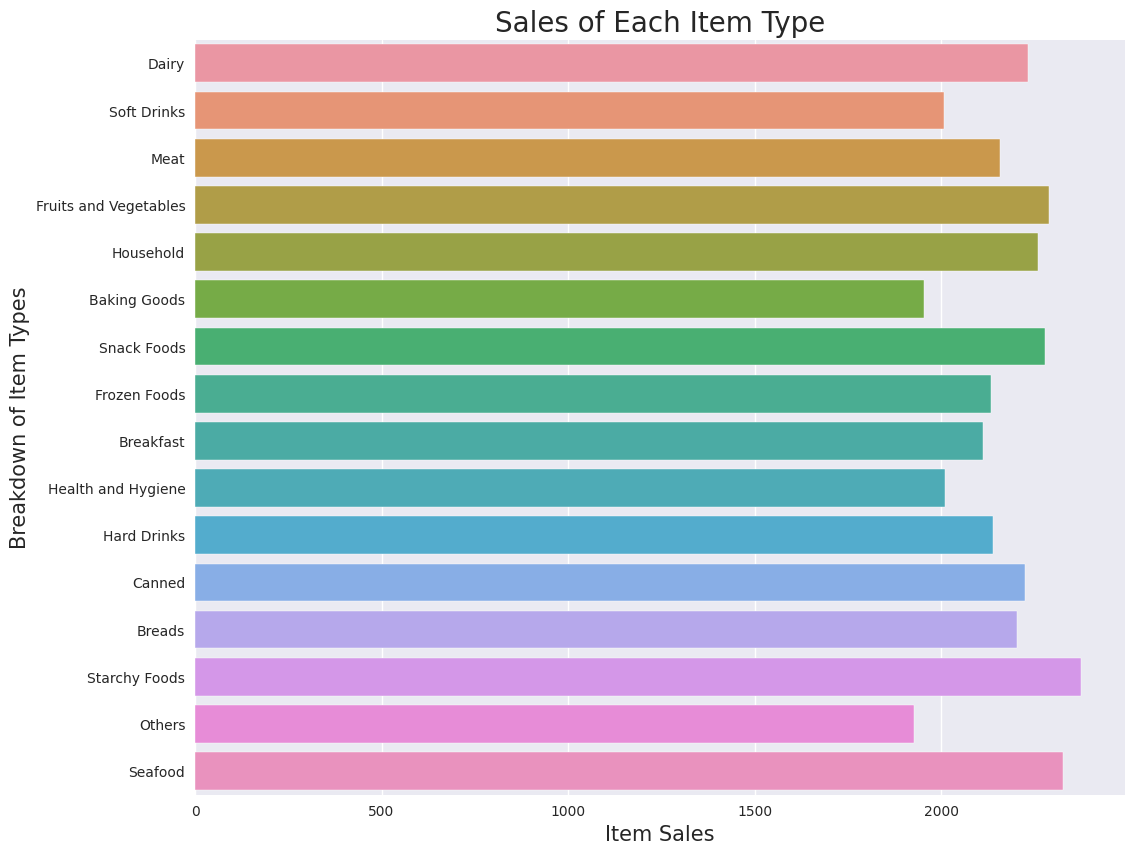

In [181]:
#Comparing the different products and their sales across all stores.


Sales_of_Each_Item_Type = plt.figure(figsize=(12,10), dpi= 100)
sns.barplot(data = df, y = 'Item_Type', x = 'Item_Outlet_Sales', ci = None)
ax.xaxis.set_major_formatter(price_fmt)
plt.title('Sales of Each Item Type', fontsize = 20)
plt.ylabel('Breakdown of Item Types', fontsize = 15)
plt.xlabel('Item Sales', fontsize =15)
Sales_of_Each_Item_Type.savefig('Sales_of_Each_Item_Type.png',  bbox_inches="tight")
files.download('Sales_of_Each_Item_Type.png')

# Begin Machine learning Pre-Processing

## Wrangling Data

In [182]:
ML_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [183]:
ML_df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [184]:
ML_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [185]:
ML_df.duplicated().sum()

0

#PreProcessing

In [186]:
ML_df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [187]:
#Ordinal encode some errors.

ML_df['Item_Fat_Content'].replace({'Low Fat':0, 'LF':0, 'low fat':0, 'Regular':1, 'reg':1})

#Identify the features (X) and target (y): Assign the "Item_Outlet_Sales" column as your target and the rest of the relevant variables as your features matrix. 
X = ML_df.drop(columns = ['Item_Outlet_Sales', 'Item_Identifier'])

y = ML_df['Item_Outlet_Sales']

#Perform a train test split 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [188]:
#Create Preprocessor

from sklearn.pipeline import make_pipeline
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

freq_imputer = SimpleImputer(strategy='most_frequent')
median_imputer = SimpleImputer(strategy='median')

ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False )
scaler = StandardScaler()

num_pipe = make_pipeline(median_imputer, scaler)
cat_pipe = make_pipeline(freq_imputer, ohe)

num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fe2014fdd90>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fe2014fdb10>)])

In [189]:
# fit ColumnTransformer on the training data
preprocessor.fit(X_train)
# transform both the training and testing data (this will output a NumPy array)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)


#Check to make sure all values are imputed correctly
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed


# change the result back to a dataframe
X_train_processed = pd.DataFrame(X_train_processed)
X_test_processed = pd.DataFrame(X_test_processed)


0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (6392, 45)




In [190]:
X_train_processed.head()

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,0.827485,-0.712775,1.828109,1.327849,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.566644,-1.291052,0.603369,1.327849,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.121028,1.813319,0.244541,0.136187,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.158464,-1.004931,-0.952591,0.732018,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.538870,-0.965484,-0.336460,0.493686,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


#Dummy Model

In [191]:
#Establishing Baseline

dummy_reg = DummyRegressor(strategy='mean')

dummy_pipe = make_pipeline(preprocessor, dummy_reg)

dummy_pipe.fit(X_train_processed, y_train)

train_pred = dummy_pipe.predict(X_train_processed)
test_pred = dummy_pipe.predict(X_test_processed)



In [192]:
def eval_regression(true, pred):
  """Takes true and predicted values (arrays) and prints MAE, MSE, RMSE and R2"""
  mae = mean_absolute_error(true, pred)
  mse = mean_squared_error(true, pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(true, pred)

  print(f'MAE {mae},\n MSE {mse},\n RMSE: {rmse},\n R^2: {r2} ')

In [193]:
eval_regression(y_train, train_pred)

MAE 1360.2184410159132,
 MSE 2959455.7045265585,
 RMSE: 1720.306863477141,
 R^2: 0.0 


In [194]:
eval_regression(y_test, test_pred)

MAE 1326.121044678208,
 MSE 2772144.4627103633,
 RMSE: 1664.9758144520788,
 R^2: -0.004772483978719766 


#Linear Regression Modeling

In [195]:
#Build a linear regression model.

reg = LinearRegression()
reg_pipe = make_pipeline(scaler, reg)
reg_pipe.fit(X_train_processed,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [196]:
X_test_predictions = reg_pipe.predict(X_test_processed)
X_train_predictions = reg_pipe.predict(X_train_processed)

In [197]:
train_r2 = r2_score(y_train, X_train_predictions)
test_r2 = r2_score(y_test, X_test_predictions)

print(f'Model Training R2: {train_r2.round(2)}')
print(f'Model Testing R2: {test_r2.round(2)}')

Model Training R2: 0.56
Model Testing R2: 0.57


In [198]:
train_MSE = mean_squared_error(y_train , X_train_predictions)
test_MSE = mean_squared_error(y_test, X_test_predictions)

print(f'Model Training MSE: {train_MSE}')
print(f'Model Testing MSE: {test_MSE}')

Model Training MSE: 1297236.374852866
Model Testing MSE: 1194586.954134335


In [199]:
train_RMSE = np.sqrt(train_MSE)
test_RMSE = np.sqrt(test_MSE)

print(f'Model Training MRSE: {train_RMSE}')
print(f'Model Testing MRSE: {test_RMSE}')

Model Training MRSE: 1138.9628505148296
Model Testing MRSE: 1092.971616344329


# Regression Tree Modeling

In [200]:
#Build a simple regression tree model.

dec_tree = DecisionTreeRegressor(random_state = 42)
dec_tree.fit(X_train_processed, y_train)
train_preds = dec_tree.predict(X_train_processed)
test_preds = dec_tree.predict(X_test_processed)

In [201]:
train_score = dec_tree.score(X_train_processed, y_train)
test_score = dec_tree.score(X_test_processed, y_test)
print(train_score)
print(test_score)

1.0
0.1815372506231251


In [202]:
#Test score overfit, begin fine tuning.

dec_tree.get_depth()

45

In [203]:
depths = list(range(1, 46))
scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
    dec_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dec_tree.fit(X_train_processed, y_train)
    train_score = dec_tree.score(X_test_processed, y_test)
    test_score = dec_tree.score(X_test_processed, y_test)
    scores.loc[depth, 'Train Score'] = train_score
    scores.loc[depth, 'Test Score'] = test_score

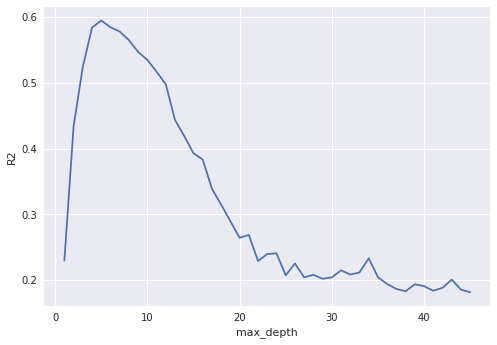

In [204]:
plt.plot(depths, scores['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2');

In [205]:
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

,Test Score,Train Score
5,0.594719,0.594719
6,0.584457,0.584457
4,0.584005,0.584005
7,0.577884,0.577884
8,0.564725,0.564725


In [206]:
dec_tree_5 = DecisionTreeRegressor(max_depth = 5, random_state = 42)
dec_tree_5.fit(X_train_processed, y_train)
train_5_score = dec_tree_5.score(X_train_processed, y_train)
test_5_score = dec_tree_5.score(X_test_processed, y_test)
print(f'Training Model R2 {train_5_score.round(2)}')
print(f'Testing Model R2 {test_5_score.round(2)}')

Training Model R2 0.6
Testing Model R2 0.59


In [207]:
dec_tree_5_train_pred = dec_tree_5.predict(X_train_processed)
dec_tree_5_test_pred = dec_tree_5.predict(X_test_processed)

In [208]:
train_MSE = mean_squared_error(y_train , dec_tree_5_train_pred)
test_MSE = mean_squared_error(y_test, dec_tree_5_test_pred)

print(f'Model Training MSE: {train_MSE}')
print(f'Model Testing MSE: {test_MSE}')

Model Training MSE: 1172166.0942888882
Model Testing MSE: 1118159.9220473527


In [209]:
train_RMSE = np.sqrt(train_MSE)
test_RMSE = np.sqrt(test_MSE)

print(f'Model Training MRSE: {train_RMSE}')
print(f'Model Testing MRSE: {test_RMSE}')

Model Training MRSE: 1082.666197075021
Model Testing MRSE: 1057.4308119434352


#Conclusion of Modeling

##With a slightly higher r2 and relatively lower RMSE 
##The regression tree is the model I would deploy for better performance.